# TensorFlow Machine Learning with Financial, New York Times and Watson Data on IBM Power 8 systems

This solution presents a time series example on IBM Power8 systems.This is based on the original Google Cloud Platform example documented at:
https://cloud.google.com/solutions/machine-learning-with-financial-time-series-data

This experiment will focus on the 'renewable energy' sector with structured and unstructured data. The original Google demo has been extended to include strcutured and unsctructured data access and processing.

In this solution, we will:

* Obtain 'renewable energy' data from a number of financial markets (indexes and ETFs).
* Obtain from the New York Times articles related to renewable energies
* Use Watson to process the articles and extract meaningful data.
* Munge that data into a usable format and perform exploratory data analysis in order to explore and validate a premise.
* Use TensorFlow to build, train and evaluate a number of models for predicting what will happen in financial markets.

## What are the differences with the Google demo ?

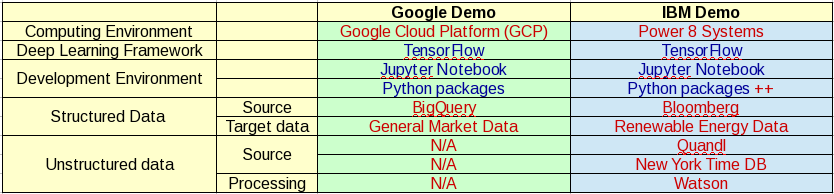

In [14]:
from IPython.display import Image
Image("IBM-Google-Demo-Env.png")


## Where data are coming from ?

The following table shows a number of stock market indices from around the globe, their closing times in Eastern Standard Time (EST), and the delay in hours between the close that index and the close of the stock market in New York. In this experiment we will use the financial data and the time difference to build a predicitve model.

|Index|Country|Closing Time (EST)|Hours Before US Close|Index|
|---|---|---|---|
|[Australian Clean Tech Index](http://www.asx.com.au/)|Australia|01:00|15|asx_cti|
|[DAX](http://en.boerse-frankfurt.de/)|Germany|11:30|4.5|dax_eusdn|
|[FTSE 100](http://www.londonstockexchange.com/home/homepage.htm)|UK|11:30|4.5|ftse_eo100|
|[Credit Suisse](https://www.credit-suisse.com/us/en/investment-banking/indices-research-analytics/indices.html)|UK|11:30|4.5|n8wh|
|[Nasdaq](http://www.nasdaq.com/)|US|16:00|0|qcln, cels|
|[S&P 500](https://www.standardandpoors.com/en_AU/web/guest/home)|US|16:00|0|icln, sp_gtced|
|[Equity Uncertainty Index](https://www.quandl.com/data/PUP/EQUITY_MKT_UNCRTAINTY_INDEX-Economic-Policy-Uncertainty-Equity-Market-Uncertainty-Index)|US|16:00|0|dei|
|[Reuters, AP, New York Times](http://developer.nytimes.com/)|US|live stream|N/A|N/A|
|[Watson Cognitive Services](https://releaseblueprints.ibm.com/display/WDA/Watson+Discovery+Service)|US|NLP Processing|N/A|N/A|

We are also going to use two additional set of data to reinforce our model:

1) a series of articles from the New York Times related to the 'clean and renewable energies'. We will try to understand if the 'sentiment' analysis has an influence on the variations of the Stock Market Energy indexes.

2) the Equity Uncertainty Index' that reflects the 'mood' of the Market will also be used in the model if we find enough correlation with the other data

## Set up

### Initial setup
All the steps below have been commented out as they need to be ran only once during a fresh installation.<br> If you want to deploy the Jupyter Notebook in your local environment, install before the following pre-requisites.

In [15]:
# Nedd to be done only once

# !pip install jupyter
# !pip install ijson
# !pip install pandas

# !pip install pandas_datareader
# !pip install httplib2
# !pip install watson_developer_cloud
# !apt-get install build-essential libssl-dev libffi-dev python-dev
# !pip install quandl
# !apt-get install python-matplotlib
# !pip install nytimesarticle
# !apt-get install python-lxml
# !pip install cython
# !apt-get install python-scipy
# !pip install scikit-learn
# !apt-get install libxml2-dev libxmlsec1-dev
# !pip install dragnet
#### !pip install tensorflow

# Install CUDA and CuDNN
#
# wget https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2v2_8.0.61-1_ppc64el-deb
# dpkg -i cuda-repo-ubuntu1604-8-0-local-ga2v2_8.0.61-1_ppc64el-deb
# apt-get update
# apt-get install cuda
#
# Download cuDNN from https://developer.nvidia.com/rdp/cudnn-download  (libcudnn5_5.1.10-1+cuda8.0_ppc64el.deb)
# Note: requires a login
#
# dpkg -i libcudnn5_5.1.10-1+cuda8.0_ppc64el.deb
#
# Install Tensorflow
#
# Download the latest mldl-repo-local .deb file from wget https://download.boulder.ibm.com/ibmdl/pub/software/server/mldl/mldl-repo-local_3.3.0_ppc64el.deb
# dpkg -i mldl-repo-local*.deb
# apt-get update
# apt-get install tensorflow



### Import libraries

First, import necessary libraries. All these libraries are installed using 'pip install <package name>.

In [16]:
import StringIO
import json
import ijson
import sys
sys.path.insert(0, "/opt/DL/tensorflow/lib/python2.7/site-packages/")
import os
import requests
import random
import httplib2
import urllib2 
from base64 import b64encode
import pandas as pd
import pandas_datareader.data as web
import datetime
import time
import calendar
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix
from pandas.tseries.offsets import *

import time

from watson_developer_cloud import AlchemyDataNewsV1
import quandl
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from nytimesarticle import articleAPI
# api = articleAPI('e232f0c680594b489111a6e7c41cba2c')

from dragnet import content_extractor, content_comments_extractor

%matplotlib inline


## Get, merge and unify Stock Market data
In this current experiment, the market data are coming from manually retrieved ".csv" files as some historical data are not available on the public finance websites. If you have a Bloomberg account you can retrieve all the data using the Bloomberg Python API: https://www.bloomberglabs.com/api/libraries/

In [17]:
start = datetime.date(2014, 1, 2)
end = datetime.date(2017, 2, 13)
# print '{:%Y-%m-%d}'.format(start)
# print '{:%Y-%m-%d}'.format(end)

# create the index
all_days = pd.date_range(start, end, freq='D')

# Australian Clean Tech Index (asx_cti)
ctius = pd.read_csv('CTIUS.csv')
ctius = ctius.set_index(pd.to_datetime(ctius['Date']))

# Nasdaq Clean Edge Green Energy Index
# cels = pd.read_csv('cels.csv', index_col='Date')
cels = pd.read_csv('cels.csv')
cels = cels.set_index(pd.to_datetime(cels['Date']))

# Merge the data 
data = pd.merge(ctius, cels, left_index=True, right_index=True, how='outer')

# FTSE, S&P, DAX Clean Energy Index
# europe_index = pd.read_csv('DAX-SP-FTSE-index.csv', index_col='Date')
europe_index = pd.read_csv('DAX-SP-FTSE-index.csv')
europe_index = europe_index.set_index(pd.to_datetime(europe_index['Date']))

# Merge the data 
data = pd.merge(data, europe_index, left_index=True, right_index=True, how='outer')

# drop the extra 'Date' columns created during the merge
data.drop('Date_x', axis=1, inplace=True)
data.drop('Date_y', axis=1, inplace=True)

# Credit Suisse
n8wh = pd.read_csv('n8wh.csv')
n8wh = n8wh.set_index(pd.to_datetime(n8wh['Date']))

# Merge the data 
data = pd.merge(data, n8wh, left_index=True, right_index=True, how='outer')

# Nasdaq Clean Edge
qcln = pd.read_csv('qcln.csv')
qcln = qcln.set_index(pd.to_datetime(qcln['Date']))

# Merge the data 
data = pd.merge(data, qcln, left_index=True, right_index=True, how='outer')
data.drop('Date', axis=1, inplace=True)

# iSahres S&P Clean Energy
icln = pd.read_csv('icln.csv')
icln = icln.set_index(pd.to_datetime(icln['Date']))

# Merge the data 
data = pd.merge(data, icln, left_index=True, right_index=True, how='outer')
data.drop('Date', axis=1, inplace=True)

# Pandas includes very convenient functions for filling gaps in the data.
# Stock values during the week end or holidays are not available
# so we need to fill the gaps
data = data.interpolate(method='linear', axis=0).ffill().bfill()

# Equity Uncertainty INDEX (dei)
eui = pd.read_csv('eui.csv')
eui = eui.set_index(pd.to_datetime(eui['Date']))

# Merge the data and do some cleanup
data = pd.merge(data, eui, left_index=True, right_index=True, how='outer')
data.drop('Date_x', axis=1, inplace=True)
data.drop('Date_y', axis=1, inplace=True)
data.drop('Date', axis=1, inplace=True)

# Rename column
data=data.rename(columns = {'Daily Equity Index':'dei'})

data.tail(5)
# print data.index.size


asx_cti        cels  sp_gtced  dax_eusdn  ftse_eo100  \
Date                                                                   
2017-02-09  1477.200000  211.460000    536.13     175.94      297.46   
2017-02-10  1480.020000  213.270000    542.29     176.53      299.25   
2017-02-11  1481.793333  214.273333    542.29     176.53      299.25   
2017-02-12  1483.566667  215.276667    542.29     176.53      299.25   
2017-02-13  1485.340000  216.280000    548.34     176.50      301.10   

                  n8wh   qcln      icln     dei  
Date                                             
2017-02-09  113.830000  16.08  8.400000   75.81  
2017-02-10  114.520000  16.22  8.510000  230.84  
2017-02-11  114.653333  16.30  8.536667   59.01  
2017-02-12  114.786667  16.38  8.563333  165.09  
2017-02-13  114.920000  16.46  8.590000   79.12

At this point,we've sourced 3+ years of time series for financial indices, combined the pertinent data into a single data structure, and harmonized the data to have the same number of entries.

## Get New York Times data

2,461 'Alternative and Renewable Energy' articles have been retrieved from the New York Times database by the cell below. The NYT database access is only available to registered users so the REST API calls are provided for information. Also as it takes time due to NYT API limitations, the process has been ran once and the data have been stored in JSON format in a file.

In [18]:
start = datetime.date(2014, 1, 2)
end = datetime.date(2017, 2, 13)
# print '{:%Y-%m-%d}'.format(start)
# print '{:%Y-%m-%d}'.format(end)
# print 'Start processing ....'

if os.path.isfile('nyt_article_results.json'):
    print 'Data gathered...'
else:
    all_articles = []
    payload = {'fq': 'subject.contains:("Alternative and Renewable Energy","Global Warming","Solar Energy","Wind Power","Greenhouse Gas Emissions")' ,'begin_date': '20140102' , 'end_date': '20170213'}
    r = requests.get('https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key=<your key>', params=payload)
    data = json.loads(r.text)
    # print data
    total_hits=data['response']['meta']['hits']
    print 'Number of articles to process: '+str(total_hits)
    time.sleep(10)
    counter = 0
    while counter < (total_hits/10+1):
      print 'Processing '+str(counter)
      r = requests.get('https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key=<your key>', params={'fq': 'subject.contains:("Alternative and Renewable Energy","Global Warming","Solar Energy","Wind Power","Greenhouse Gas Emissions")' ,'begin_date': '20140102' , 'end_date': '20170213', 'fl': 'web_url,pub_date'  ,'sort': 'oldest', 'page': counter})
      time.sleep(10)
      counter = counter + 1
      data = json.loads(r.text)
      with open('nyt_article_temp.json', 'a') as f:
          f.write(json.dumps(data,indent=2))
          f.close()  
      for a_doc in data['response']['docs']:
        url = a_doc['web_url']
        publication_date = a_doc['pub_date']
        a_articles_dict = {"URL": url, "Publication Date" : publication_date}
        all_articles.append(a_articles_dict)
    with open('nyt_article_results.json', 'w') as f:
      f.write(json.dumps(all_articles,indent=2))
      f.close()

nyt = pd.read_json('nyt_article_results.json')       
nyt.tail(4)


Data gathered...


pub_date  \
2457  2017-02-10T10:00:10+0000   
2458  2017-02-11T09:40:32+0000   
2459  2017-02-11T10:00:24+0000   
2460  2017-02-13T08:21:20+0000   

                                                web_url  
2457  https://www.nytimes.com/interactive/2017/02/10...  
2458  https://www.nytimes.com/video/us/1000000049220...  
2459  https://www.nytimes.com/2017/02/11/us/jimmy-ca...  
2460  https://www.nytimes.com/2017/02/13/opinion/a-r...

## Get Sentiment Analysis from Watson 

Next step is to get the result of the Watson sentiment analysis for each of the arcticles. The   IBM Watson Natural Language Understanding service takes as input text or url. However the Watson service complains when the article has too many links so we add another step, using the Python Dragnet package to purge the HTML formating and send the content of the link as text to Watson. 
Again, as the Watson services are only available to registered users, the API calls are provided for information only. The content of the articles have been sent to Watson for processing once and the results have been cached in local files.

In [19]:
headers = {
    'Content-Type': 'application/json',
}

def watson_request(content):
    data = '{"text": "'+content+'","features": { "entities": { "sentiment": true, "limit": 1 }}}'
    response = requests.post('https://gateway.watsonplatform.net/natural-language-understanding/api/v1/analyze?version=2017-02-27', headers=headers, data=data, auth=('<password>', '<user id>'))
    # return json.dumps(response.json(), indent=4)
    return response.text

if os.path.isfile('watson-results.csv'):
    print 'Data processed...'
else:
    res = json.loads(open('nyt_article_results.json').read())
    counter = 0

    articles = []
    for result in res:
         # print 'Processing '+ str(counter)
         dic = {}
         dic['url'] = result['web_url']
         dic['date'] = result['pub_date']
         # fetch HTML
         url = result['web_url']
         # print url
    
         r = requests.get(url)
         # get main article without comments
         content = content_extractor.analyze(r.content) 
         response = watson_request(content)
         # print response
     
         # check if a 'score' field is returned
         if "score" not in response:    
            score = 0
         else:   
             resp_dict = json.loads(response)['entities']
             # print resp_dict
             n = json.dumps(resp_dict)  
             val = json.loads(n) 
             # print val
             score = val[0]['sentiment']['score']
     
         if score < 0:   
             dic['negative'] = abs(score)
             dic['positive'] = 0
         else:
             dic['positive'] = score
             dic['negative'] = 0
         articles.append(dic)
    
         counter = counter + 1
         time.sleep(1)
    
    nyt_df = pd.DataFrame(articles) 
    nyt_df['index'] = pd.to_datetime(nyt_df['date'])

    # set index
    nyt_df = nyt_df.set_index(['index'])

    nyt_df.drop('date', axis=1, inplace=True)

    # Save dataframe to file
    nyt_df.to_csv('watson-results.csv', sep='\t', encoding='utf-8')

# Load the file previously processed by the Watson Service.
watson_data = pd.read_csv('watson-results.csv', sep='\t')

temp_data = watson_data

# format the dataframe to get the date as the index
watson_data['index'] = pd.to_datetime(watson_data['index'])
# set index
watson_data = watson_data.set_index(['index'])

# resample based on the date
# watson_data = watson_data.resample('D').mean()
watson_data = watson_data.resample('D').mean()
# change NaN by zeros
watson_data = watson_data.fillna(0)
# Replace 0 by .0000001 to avoid divide-by-zero errors
watson_data = watson_data.replace(0,.000001)

watson_data.to_csv('watson.csv', sep=' ')

# merge 
data = pd.merge(data, watson_data, left_index=True, right_index=True, how='outer')

# watson_data.head(10) 
temp_data.head(10)

Data processed...


index  negative  positive  \
0 2014-01-03 00:00:00  0.241033  0.000000   
1 2014-01-02 17:50:37  0.000000  0.244613   
2 2014-01-05 00:00:00  0.000000  0.122338   
3 2014-01-04 00:00:00  0.088218  0.000000   
4 2014-01-04 00:00:00  0.000000  0.000000   
5 2014-01-06 00:00:00  0.336110  0.000000   
6 2014-01-06 02:57:34  0.000000  0.000000   
7 2014-01-06 09:58:40  0.000000  0.229351   
8 2014-01-07 00:00:00  0.538351  0.000000   
9 2014-01-08 00:00:00  0.360546  0.000000   

                                                 url  
0  http://www.nytimes.com/2014/01/03/world/asia/k...  
1  http://www.nytimes.com/video/business/10000000...  
2  http://www.nytimes.com/2014/01/05/automobiles/...  
3  http://www.nytimes.com/2014/01/04/business/ene...  
4  http://www.nytimes.com/slideshow/2014/01/04/bu...  
5  http://www.nytimes.com/2014/01/06/world/europe...  
6  http://india.blogs.nytimes.com/2014/01/06/a-t-...  
7  http://dotearth.blogs.nytimes.com/2014/01/06/i...  
8  http://www.nytimes.com/2014/01/07/science/eart...  
9  http://www.nytimes.com/2014/01/08/opinion/curb...

## Exploratory data analysis

Exploratory Data Analysis (EDA) is foundational to working with machine learning, and any other sort of analysis. EDA is about understanding the assumptions and why we are making those assumptions. 
First, take a look at the data.

In [20]:
data.tail(5)

asx_cti        cels  sp_gtced  dax_eusdn  ftse_eo100  \
Date                                                                   
2017-02-09  1477.200000  211.460000    536.13     175.94      297.46   
2017-02-10  1480.020000  213.270000    542.29     176.53      299.25   
2017-02-11  1481.793333  214.273333    542.29     176.53      299.25   
2017-02-12  1483.566667  215.276667    542.29     176.53      299.25   
2017-02-13  1485.340000  216.280000    548.34     176.50      301.10   

                  n8wh   qcln      icln     dei  negative  positive  
Date                                                                 
2017-02-09  113.830000  16.08  8.400000   75.81  0.000001  0.000001  
2017-02-10  114.520000  16.22  8.510000  230.84  0.175525  0.000001  
2017-02-11  114.653333  16.30  8.536667   59.01  0.112716  0.000001  
2017-02-12  114.786667  16.38  8.563333  165.09  0.000001  0.000001  
2017-02-13  114.920000  16.46  8.590000   79.12  0.240870  0.000001

We can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.

Plot the data.

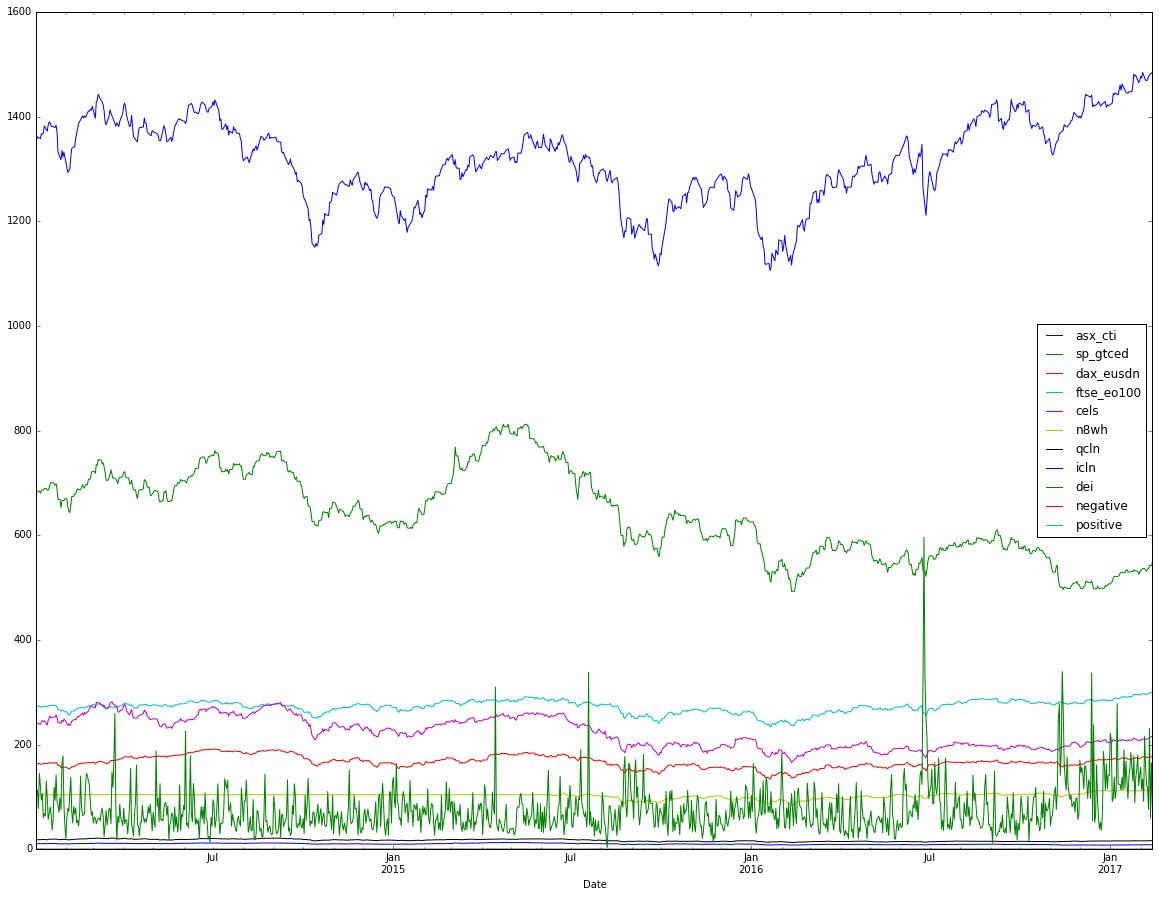

In [21]:
# N.B. A super-useful trick-ette is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = pd.concat([data['asx_cti'],
  data['sp_gtced'],
  data['dax_eusdn'],
  data['ftse_eo100'],
  data['cels'],
  data['n8wh'],
  data['qcln'],
  data['icln'],
  data['dei'],               
  data['negative'],
  data['positive']], axis=1).plot(figsize=(20, 15))

As expected, the structure isn't uniformly visible for the indices. Divide each value in an individual index by the maximum value for that index., and then replot. The maximum value of all indices will be 1. 

In [22]:
data['asx_cti_scaled'] = data['asx_cti'] / max(data['asx_cti'])
data['sp_gtced_scaled'] = data['sp_gtced'] / max(data['sp_gtced'])
data['dax_eusdn_scaled'] = data['dax_eusdn'] / max(data['dax_eusdn'])
data['ftse_eo100_scaled'] = data['ftse_eo100'] / max(data['ftse_eo100'])
data['cels_scaled'] = data['cels'] / max(data['cels'])
data['n8wh_scaled'] = data['n8wh'] / max(data['n8wh'])
data['qcln_scaled'] = data['qcln'] / max(data['qcln'])
data['icln_scaled'] = data['icln'] / max(data['icln'])
data['dei_scaled'] = data['dei'] / max(data['dei'])
data['positive_scaled'] = data['positive']
data['negative_scaled'] = data['negative']


# data['positive_scaled'] = data['positive'] / max(data['positive'])
# data['negative_scaled'] = data['negative'] / max(data['negative'])

data.tail(5)

asx_cti        cels  sp_gtced  dax_eusdn  ftse_eo100  \
Date                                                                   
2017-02-09  1477.200000  211.460000    536.13     175.94      297.46   
2017-02-10  1480.020000  213.270000    542.29     176.53      299.25   
2017-02-11  1481.793333  214.273333    542.29     176.53      299.25   
2017-02-12  1483.566667  215.276667    542.29     176.53      299.25   
2017-02-13  1485.340000  216.280000    548.34     176.50      301.10   

                  n8wh   qcln      icln     dei  negative       ...         \
Date                                                            ...          
2017-02-09  113.830000  16.08  8.400000   75.81  0.000001       ...          
2017-02-10  114.520000  16.22  8.510000  230.84  0.175525       ...          
2017-02-11  114.653333  16.30  8.536667   59.01  0.112716       ...          
2017-02-12  114.786667  16.38  8.563333  165.09  0.000001       ...          
2017-02-13  114.920000  16.46  8.590000   79.12  0.240870       ...          

            sp_gtced_scaled  dax_eusdn_scaled  ftse_eo100_scaled  cels_scaled  \
Date                                                                            
2017-02-09         0.659893          0.917884           0.987911     0.750497   
2017-02-10         0.667475          0.920962           0.993856     0.756921   
2017-02-11         0.667475          0.920962           0.993856     0.760482   
2017-02-12         0.667475          0.920962           0.993856     0.764043   
2017-02-13         0.674922          0.920806           1.000000     0.767604   

            n8wh_scaled  qcln_scaled  icln_scaled  dei_scaled  \
Date                                                            
2017-02-09     0.990515     0.752457     0.645161    0.127157   
2017-02-10     0.996519     0.759008     0.653610    0.387192   
2017-02-11     0.997680     0.762752     0.655658    0.098979   
2017-02-12     0.998840     0.766495     0.657706    0.276908   
2017-02-13     1.000000     0.770239     0.659754    0.132709   

            positive_scaled  negative_scaled  
Date                                          
2017-02-09         0.000001         0.000001  
2017-02-10         0.000001         0.175525  
2017-02-11         0.000001         0.112716  
2017-02-12         0.000001         0.000001  
2017-02-13         0.000001         0.240870  

[5 rows x 22 columns]

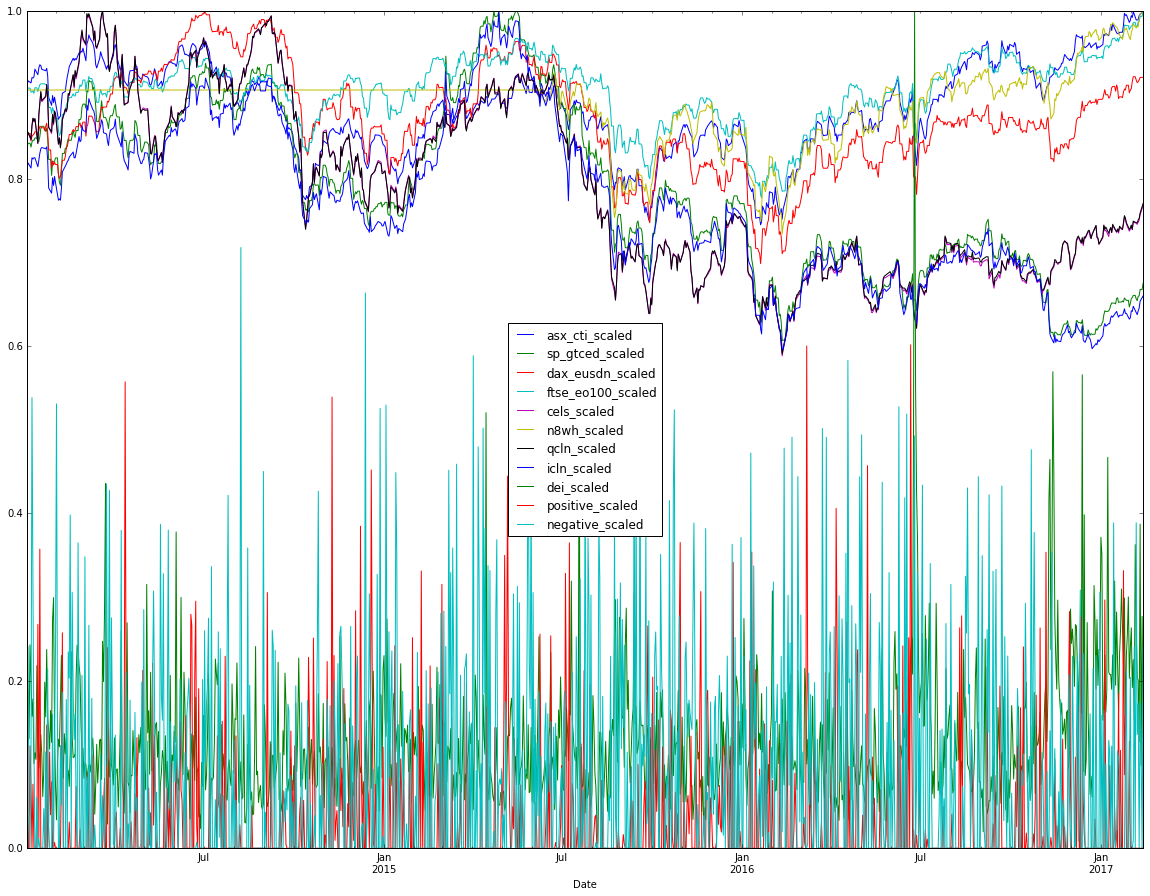

In [23]:
_ = pd.concat([data['asx_cti_scaled'],
  data['sp_gtced_scaled'],
  data['dax_eusdn_scaled'],
  data['ftse_eo100_scaled'],
  data['cels_scaled'],
  data['n8wh_scaled'],
  data['qcln_scaled'],
  data['icln_scaled'],
  data['dei_scaled'],
  data['positive_scaled'],
  data['negative_scaled']], axis=1).plot(figsize=(20, 15))

We can see that, over the three-year period, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises. This is an good start, though not the complete story. Next, plot autocorrelations for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

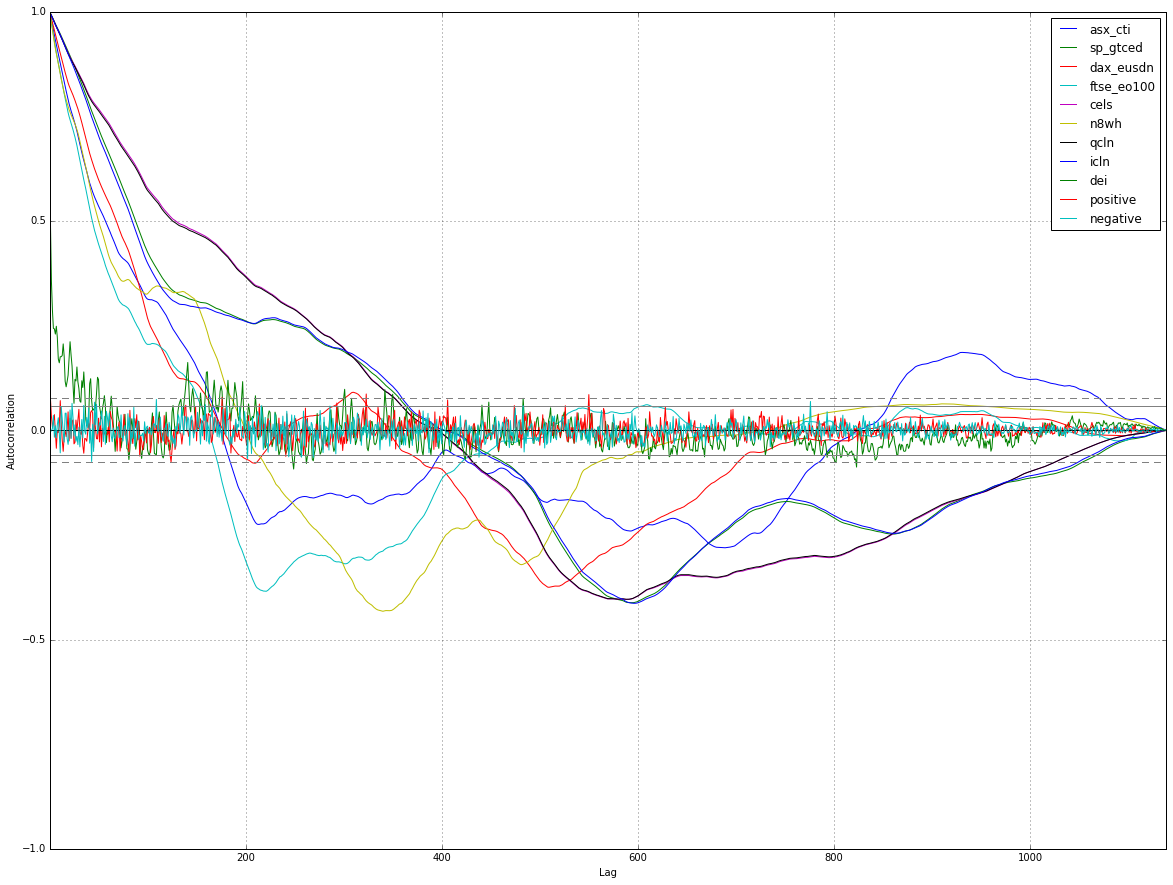

In [24]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(data['asx_cti'], label='asx_cti')
_ = autocorrelation_plot(data['sp_gtced'], label='sp_gtced')
_ = autocorrelation_plot(data['dax_eusdn'], label='dax_eusdn')
_ = autocorrelation_plot(data['ftse_eo100'], label='ftse_eo100')
_ = autocorrelation_plot(data['cels'], label='cels')
_ = autocorrelation_plot(data['n8wh'], label='n8wh')
_ = autocorrelation_plot(data['qcln'], label='qcln')
_ = autocorrelation_plot(data['icln'], label='icln')
_ = autocorrelation_plot(data['dei'], label='dei')
_ = autocorrelation_plot(data['positive'], label='positive')
_ = autocorrelation_plot(data['negative'], label='negative')

_ = plt.legend(loc='upper right')

We see strong autocorrelations, positive for around 200 and 400 lagged days, depending of the indices, then going negative. This tells us something we should intuitively know: if an index is rising it tends to carry on rising, and vice-versa. It should be encouraging that what we see here conforms to what we know about financial markets.

Next, look at a scatter matrix, showing everything plotted against everything, to see how indices are correlated with each other.

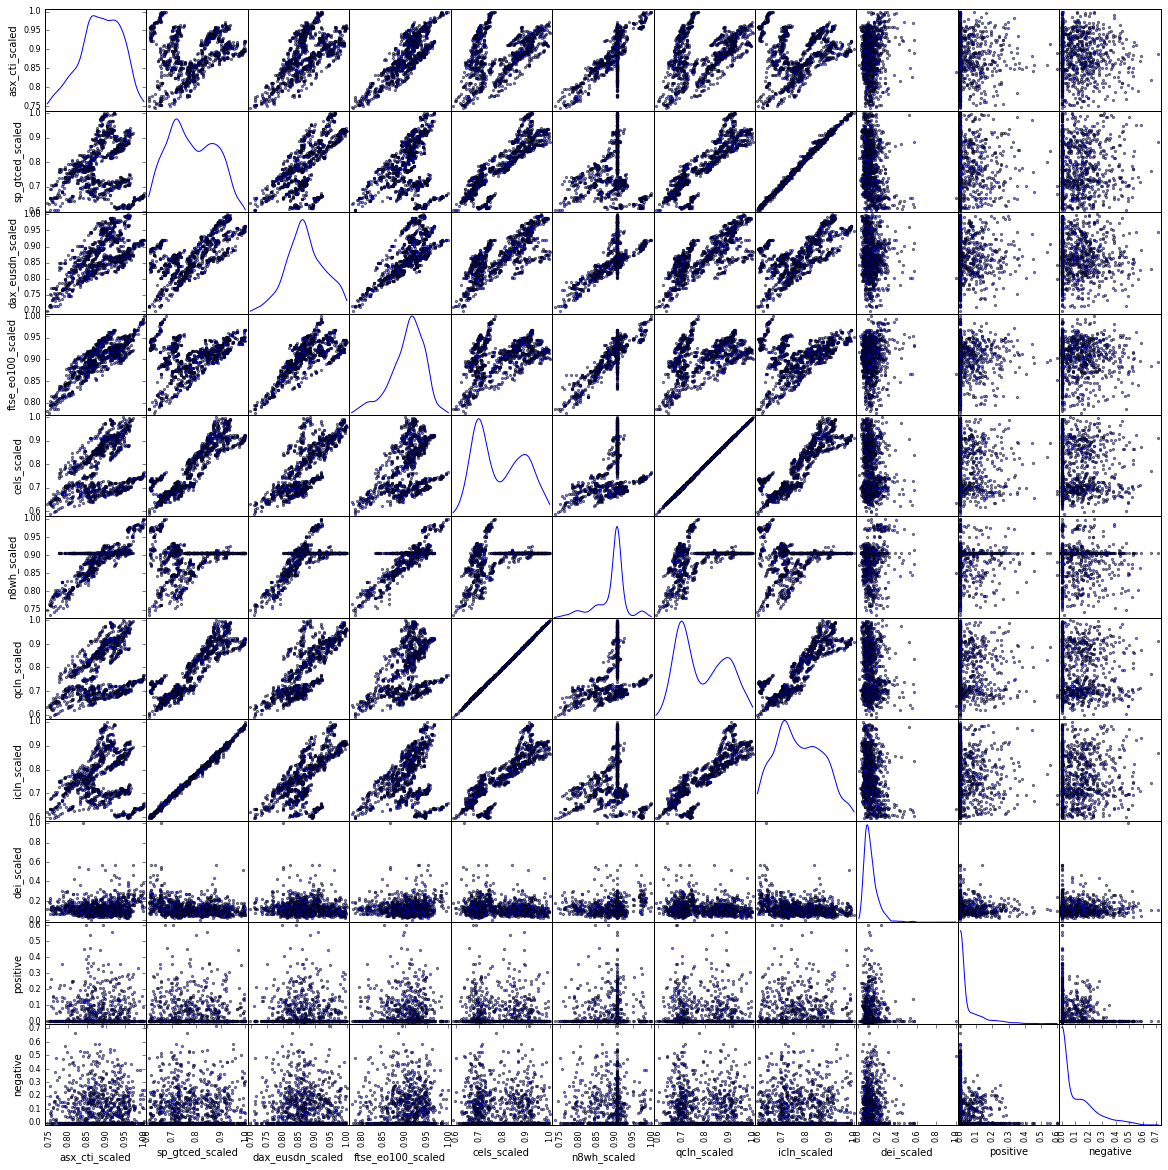

In [25]:
_ = scatter_matrix(pd.concat([data['asx_cti_scaled'],
  data['sp_gtced_scaled'],
  data['dax_eusdn_scaled'],
  data['ftse_eo100_scaled'],
  data['cels_scaled'],
  data['n8wh_scaled'],
  data['qcln_scaled'],
  data['icln_scaled'],
  data['dei_scaled'],
  data['positive'],                            
  data['negative']], axis=1), figsize=(20, 20), diagonal='kde')  # kernel density estimate (KDE)

You can see significant correlations, further evidence that the premise is workable and one market can be influenced by another. 

The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:

`ln(Vt/Vt-1)`

There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series.

Calculate and plot the log returns in a new DataFrame.

In [26]:
log_return_data = pd.DataFrame()

log_return_data['asx_cti_log_return'] = np.log(data['asx_cti']/data['asx_cti'].shift())
log_return_data['sp_gtced_log_return'] = np.log(data['sp_gtced']/data['sp_gtced'].shift())
log_return_data['dax_eusdn_log_return'] = np.log(data['dax_eusdn']/data['dax_eusdn'].shift())
log_return_data['ftse_eo100_log_return'] = np.log(data['ftse_eo100']/data['ftse_eo100'].shift())
log_return_data['cels_log_return'] = np.log(data['cels']/data['cels'].shift())
log_return_data['n8wh_log_return'] = np.log(data['n8wh']/data['n8wh'].shift())
log_return_data['qcln_log_return'] = np.log(data['qcln']/data['qcln'].shift())
log_return_data['icln_log_return'] = np.log(data['icln']/data['icln'].shift())
log_return_data['dei_log_return'] = np.log(data['dei']/data['dei'].shift())
log_return_data['positive_log_return'] = np.log(data['positive']/data['positive'].shift())
log_return_data['negative_log_return'] = np.log(data['negative']/data['negative'].shift())

# log_return_data.describe()

Looking at the log returns, we see that the mean, min, max are all similar. We could go further and center the series on zero, scale them, and normalize the standard deviation, but there's no need to do that at this point. Let's move forward with plotting the data, and iterate if necessary.

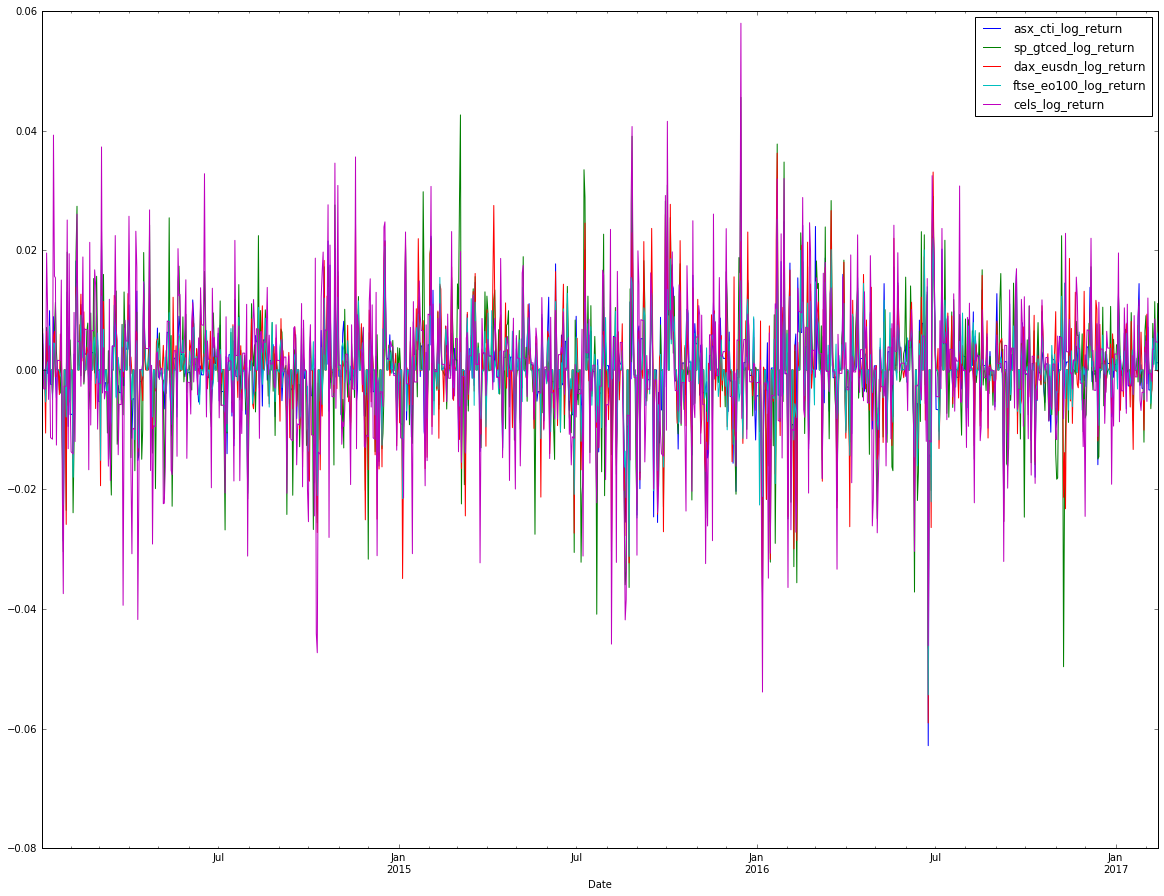

In [27]:
_ = pd.concat([log_return_data['asx_cti_log_return'],
  log_return_data['sp_gtced_log_return'],
  log_return_data['dax_eusdn_log_return'],
  log_return_data['ftse_eo100_log_return'],
  log_return_data['cels_log_return']], axis=1).plot(figsize=(20, 15))
 

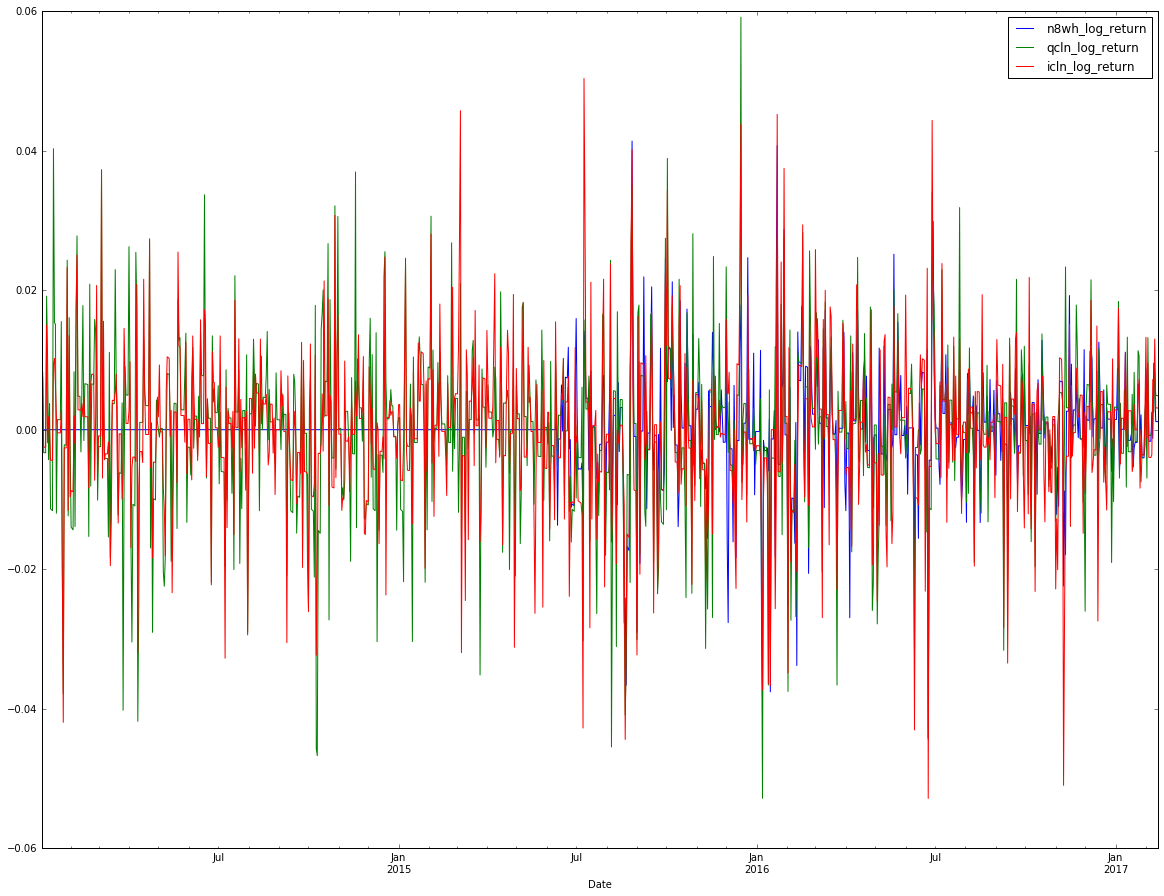

In [28]:
_ = pd.concat([log_return_data['n8wh_log_return'],
  log_return_data['qcln_log_return'],
  log_return_data['icln_log_return']], axis=1).plot(figsize=(20, 15))
#  log_return_data['dei_log_return'],
#  log_return_data['positive_log_return'],
#  log_return_data['negative_log_return']], axis=1).plot(figsize=(20, 15))

We can see from the plot that the log returns of our indices are similarly scaled and centered, with no visible trend in the data. It's looking good, so now look at autocorrelations.

Look at a scatterplot to see how the log return indices correlate with each other.

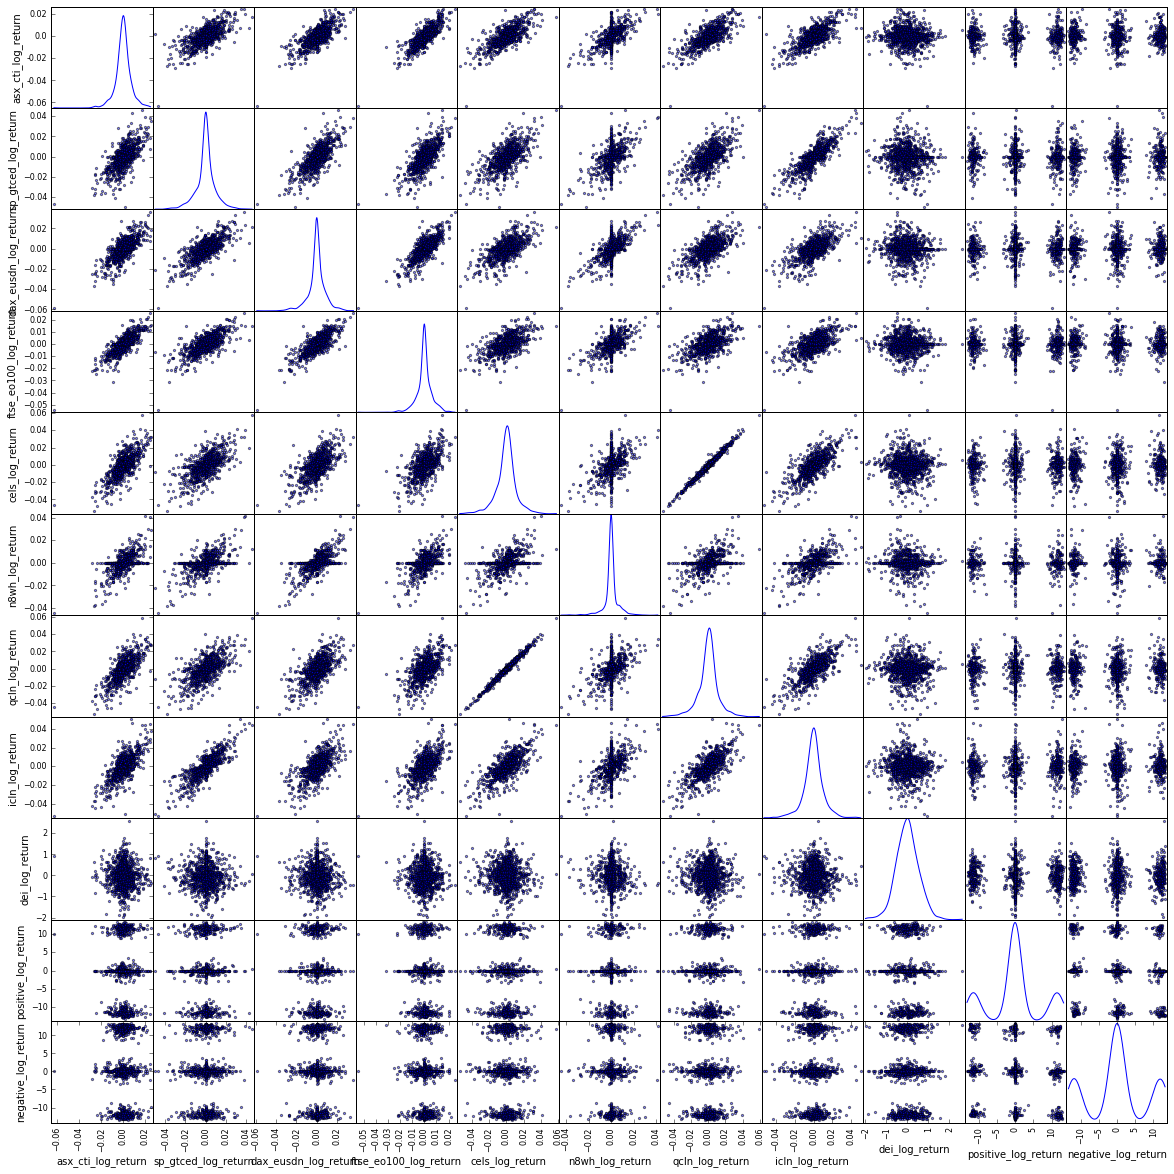

In [29]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

The story with the previous scatter plot for log returns is more subtle and more interesting. The US indices are strongly correlated, as expected. The other indices, less so, which is also expected. But there is structure and signal there. Now let's move forward and start to quantify it so we can start to choose features for our model.

First look at how the log returns for the closing value of the Trust NASDAQ Cln Edge GrnEngyETF (QCLN) and/or iShares Global Clean Energy ETF (ICLN) correlate with the closing values of other indices available on the same day. This essentially means to assume the indices that close before the QCLN and ICLN (non-US indices) are available and the others (US indices) are not.

In [18]:
tmp = pd.DataFrame()
tmp['qcln_0'] = log_return_data['qcln_log_return']     # same day
tmp['asx_0'] = log_return_data['asx_cti_log_return']
tmp['ftse_0'] = log_return_data['ftse_eo100_log_return']
tmp['dax_0'] = log_return_data['dax_eusdn_log_return']
tmp['n8wh_0'] = log_return_data['n8wh_log_return']
tmp['icln_1'] = log_return_data['icln_log_return'].shift()  # can't get same day value so use previous day
tmp['gtced_1'] = log_return_data['sp_gtced_log_return'].shift()
tmp['cels_1'] = log_return_data['cels_log_return'].shift()
tmp['dei_1'] = log_return_data['dei_log_return'].shift()
tmp['positive_1'] = log_return_data['positive_log_return']
tmp['negative_1'] = log_return_data['negative_log_return'].shift(2)

tmp.corr().iloc[:,0]

qcln_0        1.000000
asx_0         0.729750
ftse_0        0.575219
dax_0         0.633052
n8wh_0        0.489117
icln_1        0.113133
gtced_1       0.068060
cels_1        0.125155
dei_1         0.033454
positive_1    0.006359
negative_1   -0.006487
Name: qcln_0, dtype: float64

Here, we are directly working with the premise. We're correlating the close of the Trust NASDAQ Cln Edge GrnEngyETF (QCLN) with signals available before the close of the US markets.  And we can see that the Trust NASDAQ Cln Edge GrnEngyETF (QCLN) close is correlated with the Austalian index at .72 which is a very strong correlation and the European indices at around 0.60 for the FTSE and DAX, which is also a strong correlation. 

Now look at how the log returns for the NASDAQ Cln Edge GrnEngyETF (QCLN) closing values correlate with index values from the previous day to see if they previous closing is predictive. Following from the premise that financial markets are Markov processes, there should be little or no value in historical values.

In [19]:
tmp = pd.DataFrame()
tmp['qcln_0'] = log_return_data['qcln_log_return']   
tmp['asx_0'] = log_return_data['asx_cti_log_return'].shift()
tmp['ftse_0'] = log_return_data['ftse_eo100_log_return'].shift()
tmp['dax_0'] = log_return_data['dax_eusdn_log_return'].shift()
tmp['n8wh_0'] = log_return_data['n8wh_log_return'].shift()
tmp['icln_1'] = log_return_data['icln_log_return'].shift(2)  
tmp['gtced_1'] = log_return_data['sp_gtced_log_return'].shift(2)
tmp['cels_1'] = log_return_data['cels_log_return'].shift(2)
tmp['dei_1'] = log_return_data['dei_log_return'].shift(2)
tmp['positive_1'] = log_return_data['positive_log_return'].shift(1)
tmp['negative_1'] = log_return_data['negative_log_return'].shift(1)
tmp.corr().iloc[:,0]

qcln_0        1.000000
asx_0         0.114976
ftse_0        0.039147
dax_0         0.071568
n8wh_0        0.115682
icln_1        0.044220
gtced_1       0.032662
cels_1        0.058135
dei_1         0.016694
positive_1    0.033764
negative_1   -0.024646
Name: qcln_0, dtype: float64

We see little to no correlation in this data, meaning that yesterday's values are no practical help in predicting today's close. Let's go one step further and look at correlations between today and the the day before yesterday.

## Summing up the EDA

Summing up:

* Australia index from the same day is a strong predictor for the Nasdaq Energy Index close.
* European indices from the same day were a significant predictor for the Nasdaq Energy Index close.
* Indices from previous days were not good predictors for the Nasdaq Energy Index close.

## PowerAI / TensorFlow

PowerAI is IBM’s machine learning framework for companies that use servers based on its Power processors and NVIDIA’s NVLink high-speed interconnects that allow for data to pass extremely quickly between the processor and the GPU that does most of the deep learning calculations. PowerAI now supports Google’s popular Tensorflow machine learning library.
[TensorFlow](https://tensorflow.org) is an open source software library, initiated by Google, for numerical computation using data flow graphs. 

### Training and Test data

We'll use 80% of our data for training and 20% for testing.

In [32]:
log_return_data['qcln_log_return_positive'] = 0
log_return_data.ix[log_return_data['qcln_log_return'] >= 0, 'qcln_log_return_positive'] = 1
log_return_data['qcln_log_return_negative'] = 0
log_return_data.ix[log_return_data['qcln_log_return'] < 0, 'qcln_log_return_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'qcln_log_return_positive', 'qcln_log_return_negative',
    'qcln_log_return_1', 'qcln_log_return_2', 'qcln_log_return_3',
    'icln_log_return_1', 'icln_log_return_2', 'icln_log_return_3',
    'sp_gtced_log_return_1', 'sp_gtced_log_return_2', 'sp_gtced_log_return_3',
    'cels_log_return_1', 'cels_log_return_2', 'cels_log_return_3',  
    'asx_cti_log_return_0', 'asx_cti_log_return_1', 'asx_cti_log_return_2',
    'ftse_eo100_log_return_0', 'ftse_eo100_log_return_1', 'ftse_eo100_log_return_2',  
    'dax_eusdn_log_return_0', 'dax_eusdn_log_return_1', 'dax_eusdn_log_return_2', 
    'n8wh_log_return_0', 'n8wh_log_return_1', 'n8wh_log_return_2',
    'dei_log_return_1', 'dei_log_return_2', 'dei_log_return_3',
    'positive_log_return_0', 'positive_log_return_1', 'positive_log_return_2',
    'negative_log_return_0', 'negative_log_return_1', 'negative_log_return_2'])

for i in range(4, len(log_return_data)):
  qcln_log_return_positive = log_return_data['qcln_log_return_positive'].ix[i]
  qcln_log_return_negative = log_return_data['qcln_log_return_negative'].ix[i]
  qcln_log_return_1 = log_return_data['qcln_log_return'].ix[i-1]
  qcln_log_return_2 = log_return_data['qcln_log_return'].ix[i-2]
  qcln_log_return_3 = log_return_data['qcln_log_return'].ix[i-3]
  icln_log_return_1 = log_return_data['icln_log_return'].ix[i-1]
  icln_log_return_2 = log_return_data['icln_log_return'].ix[i-2]
  icln_log_return_3 = log_return_data['icln_log_return'].ix[i-3]
  sp_gtced_log_return_1 = log_return_data['sp_gtced_log_return'].ix[i-1]
  sp_gtced_log_return_2 = log_return_data['sp_gtced_log_return'].ix[i-2]
  sp_gtced_log_return_3 = log_return_data['sp_gtced_log_return'].ix[i-3]
  cels_log_return_1 = log_return_data['cels_log_return'].ix[i-1]
  cels_log_return_2 = log_return_data['cels_log_return'].ix[i-2]
  cels_log_return_3 = log_return_data['cels_log_return'].ix[i-3]
  asx_cti_log_return_0 = log_return_data['asx_cti_log_return'].ix[i]
  asx_cti_log_return_1 = log_return_data['asx_cti_log_return'].ix[i-1]
  asx_cti_log_return_2 = log_return_data['asx_cti_log_return'].ix[i-2]
  ftse_eo100_log_return_0 = log_return_data['ftse_eo100_log_return'].ix[i]
  ftse_eo100_log_return_1 = log_return_data['ftse_eo100_log_return'].ix[i-1]
  ftse_eo100_log_return_2 = log_return_data['ftse_eo100_log_return'].ix[i-2]  
  dax_eusdn_log_return_0 = log_return_data['dax_eusdn_log_return'].ix[i]
  dax_eusdn_log_return_1 = log_return_data['dax_eusdn_log_return'].ix[i-1]
  dax_eusdn_log_return_2 = log_return_data['dax_eusdn_log_return'].ix[i-2] 
  n8wh_log_return_0 = log_return_data['n8wh_log_return'].ix[i]
  n8wh_log_return_1 = log_return_data['n8wh_log_return'].ix[i-1]
  n8wh_log_return_2 = log_return_data['n8wh_log_return'].ix[i-2] 
  dei_log_return_1 = log_return_data['dei_log_return'].ix[i-1]
  dei_log_return_2 = log_return_data['dei_log_return'].ix[i-2]
  dei_log_return_3 = log_return_data['dei_log_return'].ix[i-3]
  positive_log_return_0 = log_return_data['positive_log_return'].ix[i]
  positive_log_return_1 = log_return_data['positive_log_return'].ix[i-1]
  positive_log_return_2 = log_return_data['positive_log_return'].ix[i-2] 
  negative_log_return_0 = log_return_data['negative_log_return'].ix[i]
  negative_log_return_1 = log_return_data['negative_log_return'].ix[i-1]
  negative_log_return_2 = log_return_data['negative_log_return'].ix[i-2]   
  training_test_data = training_test_data.append(
    {'qcln_log_return_positive':qcln_log_return_positive,
    'qcln_log_return_negative':qcln_log_return_negative,
    'qcln_log_return_1':qcln_log_return_1,
    'qcln_log_return_2':qcln_log_return_2,
    'qcln_log_return_3':qcln_log_return_3,
    'icln_log_return_1':icln_log_return_1,
    'icln_log_return_2':icln_log_return_2,
    'icln_log_return_3':icln_log_return_3,
    'sp_gtced_log_return_1':sp_gtced_log_return_1,
    'sp_gtced_log_return_2':sp_gtced_log_return_2,
    'sp_gtced_log_return_3':sp_gtced_log_return_3,
    'cels_log_return_1':cels_log_return_1,
    'cels_log_return_2':cels_log_return_2,
    'cels_log_return_3':cels_log_return_3,
    'asx_cti_log_return_0':asx_cti_log_return_0,
    'asx_cti_log_return_1':asx_cti_log_return_1,
    'asx_cti_log_return_2':asx_cti_log_return_2,
    'ftse_eo100_log_return_0':ftse_eo100_log_return_0,
    'ftse_eo100_log_return_1':ftse_eo100_log_return_1,
    'ftse_eo100_log_return_2':ftse_eo100_log_return_2,
    'dax_eusdn_log_return_0':dax_eusdn_log_return_0,
    'dax_eusdn_log_return_1':dax_eusdn_log_return_1,
    'dax_eusdn_log_return_2':dax_eusdn_log_return_2,
    'n8wh_log_return_0':n8wh_log_return_0,
    'n8wh_log_return_1':n8wh_log_return_1,
    'n8wh_log_return_2':n8wh_log_return_2,
    'dei_log_return_1':dei_log_return_1,
    'dei_log_return_2':dei_log_return_2,
    'dei_log_return_3':dei_log_return_3,
    'positive_log_return_0':positive_log_return_0,
    'positive_log_return_1':positive_log_return_1,
    'positive_log_return_2':positive_log_return_2,
    'negative_log_return_0':negative_log_return_0,
    'negative_log_return_1':negative_log_return_1,
    'negative_log_return_2':negative_log_return_2},
    ignore_index=True)
  
# training_test_data.describe()
training_test_data.head(3)


qcln_log_return_positive  qcln_log_return_negative  qcln_log_return_1  \
0                       0.0                       1.0          -0.003299   
1                       1.0                       0.0          -0.003309   
2                       1.0                       0.0           0.019152   

   qcln_log_return_2  qcln_log_return_3  icln_log_return_1  icln_log_return_2  \
0          -0.003288           0.008240          -0.002511          -0.002505   
1          -0.003299          -0.003288          -0.002517          -0.002511   
2          -0.003309          -0.003299           0.015010          -0.002517   

   icln_log_return_3  sp_gtced_log_return_1  sp_gtced_log_return_2  \
0           0.007533               0.000000               0.000000   
1          -0.002505              -0.005217               0.000000   
2          -0.002511               0.007115              -0.005217   

           ...            n8wh_log_return_2  dei_log_return_1  \
0          ...                          0.0          0.621201   
1          ...                          0.0         -0.179166   
2          ...                          0.0         -0.254930   

   dei_log_return_2  dei_log_return_3  positive_log_return_0  \
0         -0.373448          0.092855              -0.470146   
1          0.621201         -0.373448             -11.244397   
2         -0.179166          0.621201              11.244397   

   positive_log_return_1  positive_log_return_2  negative_log_return_0  \
0              11.714543               0.000000              11.626581   
1              -0.470146              11.714543               1.569685   
2             -11.244397              -0.470146              -0.544674   

   negative_log_return_1  negative_log_return_2  
0             -10.694424              -1.698265  
1              11.626581             -10.694424  
2               1.569685              11.626581  

[3 rows x 35 columns]

Now, create the training and test data.

In [33]:
predictors_tf = training_test_data[training_test_data.columns[2:]]

classes_tf = training_test_data[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]
test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

# training_predictors_tf.describe()
training_predictors_tf.head(3)
# training_classes_tf.head(3)

qcln_log_return_1  qcln_log_return_2  qcln_log_return_3  icln_log_return_1  \
0          -0.003299          -0.003288           0.008240          -0.002511   
1          -0.003309          -0.003299          -0.003288          -0.002517   
2           0.019152          -0.003309          -0.003299           0.015010   

   icln_log_return_2  icln_log_return_3  sp_gtced_log_return_1  \
0          -0.002505           0.007533               0.000000   
1          -0.002511          -0.002505              -0.005217   
2          -0.002517          -0.002511               0.007115   

   sp_gtced_log_return_2  sp_gtced_log_return_3  cels_log_return_1  \
0               0.000000               0.004321          -0.003172   
1               0.000000               0.000000          -0.003182   
2              -0.005217               0.000000           0.019557   

           ...            n8wh_log_return_2  dei_log_return_1  \
0          ...                          0.0          0.621201   
1          ...                          0.0         -0.179166   
2          ...                          0.0         -0.254930   

   dei_log_return_2  dei_log_return_3  positive_log_return_0  \
0         -0.373448          0.092855              -0.470146   
1          0.621201         -0.373448             -11.244397   
2         -0.179166          0.621201              11.244397   

   positive_log_return_1  positive_log_return_2  negative_log_return_0  \
0              11.714543               0.000000              11.626581   
1              -0.470146              11.714543               1.569685   
2             -11.244397              -0.470146              -0.544674   

   negative_log_return_1  negative_log_return_2  
0             -10.694424              -1.698265  
1              11.626581             -10.694424  
2               1.569685              11.626581  

[3 rows x 33 columns]

Define some metrics here to evaluate the models.

* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) -  The ability of the classifier not to label as positive a sample that is negative.
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) - The ability of the classifier to find all the positive samples.
* [F1 Score](https://en.wikipedia.org/wiki/F1_score) - A weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
* Accuracy - The percentage correctly predicted in the test data.

In [34]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
  predictions = tf.argmax(model, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tp, tn, fp, fn = \
    session.run(
      [tp_op, tn_op, fp_op, fn_op], 
      feed_dict
    )

  tpr = float(tp)/(float(tp) + float(fn))
  fpr = float(fp)/(float(tp) + float(fn))

  accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))

  recall = tpr
  precision = float(tp)/(float(tp) + float(fp))
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  
  print 'Precision = ', precision
  print 'Recall = ', recall
  print 'F1 Score = ', f1_score
  print 'Accuracy = ', accuracy

### Binary classification with TensorFlow

Now, get some tensors flowing. The model is binary classification expressed in TensorFlow.

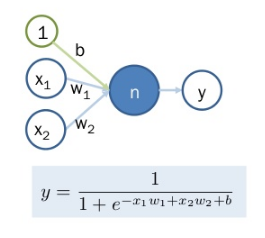

In [35]:
from IPython.display import Image
Image("binary-classification.png")


In [36]:
tf.reset_default_graph()
# sess = tf.Session()

with tf.device('/gpu:0'):

  # Define variables for the number of predictors and number of classes 
  num_predictors = len(training_predictors_tf.columns) # 24 in the default case
  num_classes = len(training_classes_tf.columns) # 2 in the default case

# Define placeholders for the data we feed into the process - feature data and actual classes.
feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, num_classes])

# Define a matrix of weights and initialize it with some small random values.
weights = tf.Variable(tf.truncated_normal([num_predictors, num_classes], stddev=0.0001))
biases = tf.Variable(tf.ones([num_classes]))

# Define our model...
# Here we take a softmax regression of the product of our feature data and weights.
model = tf.nn.softmax(tf.matmul(feature_data, weights) + biases)

# Define a cost function (we're using the cross entropy).
cost = -tf.reduce_sum(actual_classes*tf.log(model))

# Define a training step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
training_step = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(cost)   #0.0001

# sess = tf.Session()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
sess.run(init)

We'll train the model over 30,000 iterations using the full dataset each time. Every thousandth iteration we'll assess the accuracy of the model on the training data to assess progress.

In [37]:

correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

def run_it():
    for i in range(1, 30001):
      sess.run(
        training_step, 
        feed_dict={
          feature_data: training_predictors_tf.values, 
          actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
        }
      )
      if i%5000 == 0:
        print i, sess.run(
          accuracy,
          feed_dict={
            feature_data: training_predictors_tf.values, 
            actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
          }
        )

start = time.time()       
run_it()
end = time.time()
print 'Training Time = ', (end - start)

5000 0.620044
10000 0.645374
15000 0.670705
20000 0.682819
25000 0.678414
30000 0.69163
Training Time =  38.4464190006


Accuracy on the training set is ~69%.

In [38]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess, feed_dict)

Precision =  0.56862745098
Recall =  0.295918367347
F1 Score =  0.389261744966
Accuracy =  0.599118942731


Accuracy on the test set is ~60%.  

### Feed-forward neural network with two hidden layers

We'll now build a proper feed-forward neural net with two hidden layers.

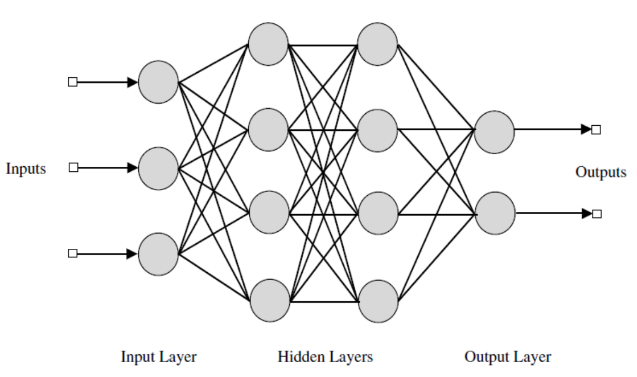

In [39]:
from IPython.display import Image
Image("feed-forward.png")


In [40]:
tf.reset_default_graph()
sess1 = tf.Session()

nl1 = 50
nl2 = 25

# Define variables for the number of predictors and number of classes 
num_predictors = len(training_predictors_tf.columns) # 33 
num_classes = len(training_classes_tf.columns) # 2 

# Define placeholders for the data we feed into the process - feature data and actual classes.
feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, 2])

# Define a matrix of weights and initialize it with some small random values.
weights1 = tf.Variable(tf.truncated_normal([num_predictors,nl1], stddev=0.0001))  #33, 50
biases1 = tf.Variable(tf.ones([nl1]))  # 50

weights2 = tf.Variable(tf.truncated_normal([nl1, nl2], stddev=0.0001))  # 50, 25
biases2 = tf.Variable(tf.ones([nl2]))  # 25
                     
weights3 = tf.Variable(tf.truncated_normal([nl2, 2], stddev=0.0001))   # 25, 2
biases3 = tf.Variable(tf.ones([2]))   # 2

hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)   # rectified linear unit (ReLU).
hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)

# Define our model...
# Here we take a softmax regression of the product of our feature data and weights.
model = tf.nn.softmax(tf.matmul(hidden_layer_2, weights3) + biases3)

# Define a cost function (we're using the cross entropy).
cost = -tf.reduce_sum(actual_classes*tf.log(model))

# Define a training step...
# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
train_op1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

# init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
sess1.run(init)

We'll train the model over 15,000 iterations using the full dataset each time. Every thousandth iteration, we'll assess the accuracy of the model on the training data to assess progress.

In [41]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 15001):  
  sess1.run(
    train_op1, 
    feed_dict={
      feature_data: training_predictors_tf.values, 
      actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    }
  )
  if i%5000 == 0:
    print i, sess1.run(
      accuracy,
      feed_dict={
        feature_data: training_predictors_tf.values, 
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
      }
    )

5000 0.917401
10000 0.986784
15000 0.993392


A significant improvement in accuracy with the training data shows that the hidden layers are adding additional capacity for learning to the model.
Looking at precision, recall, and accuracy, we can see improvement in performance.

In [42]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess1, feed_dict)
sess1.close()

Precision =  0.567901234568
Recall =  0.469387755102
F1 Score =  0.513966480447
Accuracy =  0.616740088106


## Results

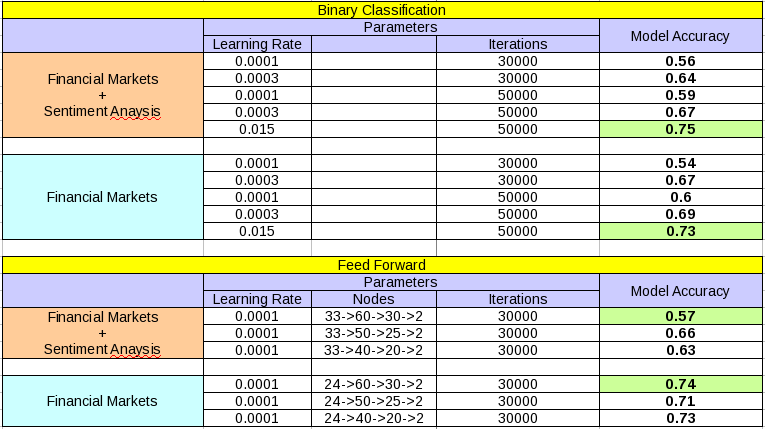

In [42]:
from IPython.display import Image
Image("NN-Results.png")


As anticipated, there is a clear dependency between the data and the Neural Network model. 

## Conclusion

Over ~75% accuracy in predicting the close of the Nasdaq Clean Energy Index is the highest we've seen achieved on this dataset. The reason for the relatively modest accuracy achieved is the dataset itself; there isn't enough signal in the current dataset but ~7 times out of 10, we were able to correctly determine if the Nasdaq Clean Energy Index would close up or down on the day, and that's objectively good.